In [1]:
import functools
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import torch
from tqdm.auto import trange

sys.path.append("..")

from trajectory import (IsDivergingPrecise, compare_trajectory,
                        order_parameter, plot_trajectory)

from common import fitting
from common.hyperparameter import HyperParameter
from common.path import DATA_DIR, FIG_DIR, RESULT_DIR
from modules import RungeKutta
from modules.utils import prune_state_dict
from train.scheduler import get_scheduler
from train.trainer import rollout

from approximator import KuramotoApproximator

In [2]:
device = torch.device("cuda:0")
exp_id = "best_RK"
test_id = "RK4_test"

result_dir = RESULT_DIR / f"kuramoto_{exp_id}"

# Load hyperparameter
hp = HyperParameter.from_yaml(result_dir / "hyperparameter.yaml")

# Load checkpoint
checkpoint = torch.load(result_dir / "best.pth", map_location=device)

# Load MAE
mae_df = pd.read_csv(result_dir / "mae.txt", sep="\t")
train_mae, val_mae = mae_df["train_mae"], mae_df["val_mae"]
rollout_mae = mae_df["rollout_mae"]
best_epoch = np.argmin(rollout_mae).item()

# Load data
test_df = pd.read_pickle(DATA_DIR / f"kuramoto_{test_id}.pkl")

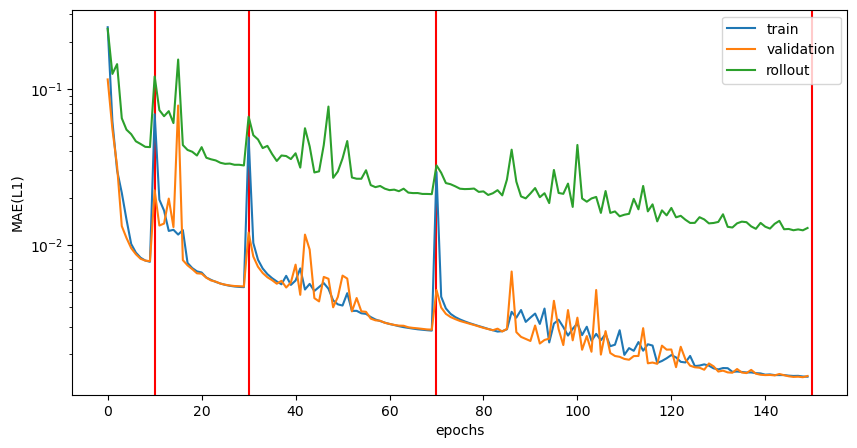

In [4]:
# Plot train history
fig, ax = plt.subplots(figsize=(10, 5))

schedular = get_scheduler(hp.scheduler)
for cycle in schedular.get_updated_epochs(hp.scheduler, len(train_mae)):
    plt.axvline(cycle, color="r")

ax.plot(train_mae, label="train")
ax.plot(val_mae, label="validation")
ax.plot(rollout_mae, label="rollout")
ax.set_xlabel("epochs")
ax.set_ylabel("MAE(L1)")
ax.set_yscale("log")
ax.legend()

fig.show()

In [ ]:
approximator = KuramotoApproximator.from_hp(hp.approximator)
approximator.load_state_dict(prune_state_dict(checkpoint["best_model_state_dict"]))
# model = RungeKutta(approximator, butcher_tableau=hp.rk).to(device)
model = RungeKutta(approximator, butcher_tableau="rk4").to(device)

kuramoto_rollout = functools.partial(
    rollout,
    model=model,
    use_amp=hp.amp,
    device=device,
    is_diverging=IsDivergingPrecise(),
)


# Rollout

In [5]:
pred_trajectories: list[npt.NDArray[np.float32]] = []
for idx in trange(len(test_df)):
    pred_trajectories.append(kuramoto_rollout(series=test_df.iloc[idx]).cpu().numpy())


  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
# with open(result_dir / f"pred_{test_id}.pkl", "wb") as f:
#     pickle.dump(pred_trajectories, f)

with open(result_dir / f"pred_{test_id}.pkl", "rb") as f:
    pred_trajectories = pickle.load(f)

# Analyze

In [6]:
times = np.array(
    [np.append(0, np.cumsum(dts.numpy(), dtype=np.float32)) for dts in test_df.dts],
    dtype=np.float32,
)
true_trajectories = [traj.numpy() for traj in test_df.trajectories]

maes = []
for idx, (true, pred) in enumerate(zip(true_trajectories, pred_trajectories)):
    print(f"{idx=}, {test_df.network_type[idx]}, N={true.shape[1]}", end=" ")
    maes.append(compare_trajectory(true, pred))
maes = np.stack(maes, axis=0)  # (# of samples, S)
print(f"Error: MAE={np.mean(maes):.4e} \t std={np.std(maes):.4e}")

idx=0, er, N=9999 MAE=0.0285, Maximum err: 6.3229 at step=754, node=6270
idx=1, er, N=9860 MAE=0.0094, Maximum err: 2.7251 at step=773, node=1749
idx=2, ba, N=10000 MAE=0.0887, Maximum err: 6.6563 at step=750, node=4320
idx=3, rr, N=10000 MAE=0.0309, Maximum err: 5.5831 at step=791, node=8392
idx=4, er, N=9887 MAE=0.0104, Maximum err: 4.9499 at step=800, node=3425
idx=5, ba, N=10000 MAE=0.0200, Maximum err: 5.1545 at step=771, node=21
idx=6, ba, N=10000 MAE=0.1565, Maximum err: 8.4467 at step=800, node=7133
idx=7, rr, N=5246 MAE=0.0045, Maximum err: 0.3824 at step=745, node=3382
idx=8, ba, N=10000 MAE=0.1094, Maximum err: 7.3854 at step=800, node=605
idx=9, ba, N=10000 MAE=0.1003, Maximum err: 7.0843 at step=685, node=1421
idx=10, ba, N=10000 MAE=0.0216, Maximum err: 6.3711 at step=770, node=238
idx=11, er, N=10000 MAE=0.0276, Maximum err: 6.5117 at step=516, node=7142
idx=12, ba, N=10000 MAE=0.0150, Maximum err: 5.6195 at step=486, node=5076
idx=13, ba, N=10000 MAE=0.0230, Maximum err

## Single sample

In [7]:
sample_idx = 10

print(test_df.network_type[sample_idx])
xticks = np.round(np.linspace(0, times[sample_idx, -1], 5), 2)
true_trajcetory = true_trajectories[sample_idx]
pred_trajectory = pred_trajectories[sample_idx]
error = true_trajcetory - pred_trajectory

ba


plot node with index: [4948 6851 9593 6335 4001 7527 4978 9001 4520  253]


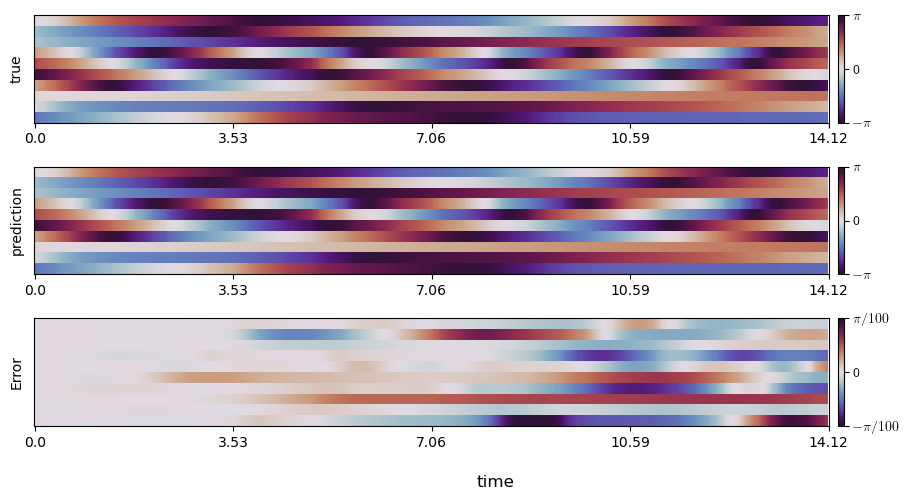

In [12]:
nodes = np.random.choice(np.arange(true_trajcetory.shape[1]), 10, replace=False)
# nodes = set()
# for idx in np.argsort(np.abs(error).sum(axis=0).flatten())[::-1]:   # max
# # for idx in np.argsort(np.abs(error).sum(axis=0).flatten()):   # min
#     idx = np.unravel_index(idx, error.shape[1:])
#     nodes.add(idx[0])
#     if len(nodes) == 10:
#         break
nodes = np.array(list(nodes))

print(f"plot node with index: {nodes}")

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 5), nrows=3)
ax1.set_ylabel("true")
im = plot_trajectory(
    ax1,
    true_trajcetory,
    nodes,
    xticks,
    cmap="twilight_shifted",
    vmin=-np.pi,
    vmax=np.pi,
)
cbar = fig.colorbar(im, ax=ax1, location="right", pad=0.01, ticks=[-np.pi, 0, np.pi])
cbar.ax.set_yticklabels([r"$-\pi$", 0, r"$\pi$"], usetex=True)

ax2.set_ylabel("prediction")
im = plot_trajectory(
    ax2,
    pred_trajectory,
    nodes,
    xticks,
    cmap="twilight_shifted",
    vmin=-np.pi,
    vmax=np.pi,
)
cbar = fig.colorbar(im, ax=ax2, location="right", pad=0.01, ticks=[-np.pi, 0, np.pi])
cbar.ax.set_yticklabels([r"$-\pi$", 0, r"$\pi$"], usetex=True)

ax3.set_ylabel("Error")
im = plot_trajectory(
    ax3,
    error,
    nodes,
    xticks,
    cmap="twilight_shifted",
    vmin=-0.01 * np.pi,
    vmax=0.01 * np.pi,
)
cbar = fig.colorbar(
    im,
    ax=ax3,
    location="right",
    pad=0.01,
    ticks=[-0.01 * np.pi, 0, 0.01 * np.pi]
    # im,
    # ax=ax3,
    # location="right",
    # pad=0.01,
    # ticks=[-0.1 * np.pi, 0, 0.1 * np.pi],
)
cbar.ax.set_yticklabels([r"$-\pi/100$", 0, r"$\pi/100$"], usetex=True)
# cbar.ax.set_yticklabels([r"$-\pi/10$", 0, r"$\pi/10$"], usetex=True)

fig.supxlabel("time")
fig.tight_layout()
# fig.savefig(f"{FIG_DIR}/kuramoto_trajectory.pdf", bbox_inches="tight", pad_inches=0.0)
fig.show()

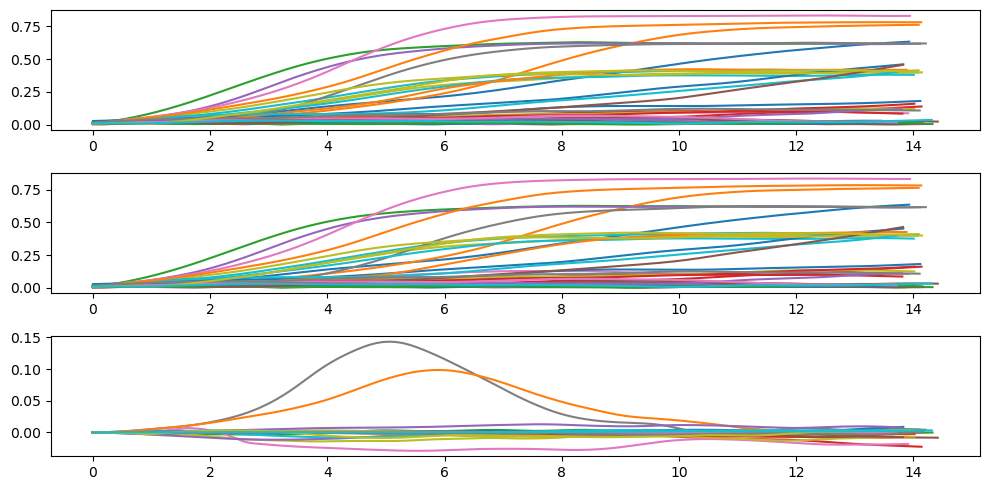

In [13]:
true_order_parameter = order_parameter(true_trajcetory)
pred_order_parameter = order_parameter(pred_trajectory)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 5), nrows=3)

for t, true_traj, pred_traj in zip(times, true_trajectories, pred_trajectories):
    true_op, pred_op = order_parameter(true_traj), order_parameter(pred_traj)
    ax1.plot(t, true_op)
    ax2.plot(t, pred_op)
    ax3.plot(t, true_op - pred_op)

fig.tight_layout()
fig.show()

## Statisics over samples

slope: 0.0719 pm 0.0315
slope of averaged curve: 0.0482


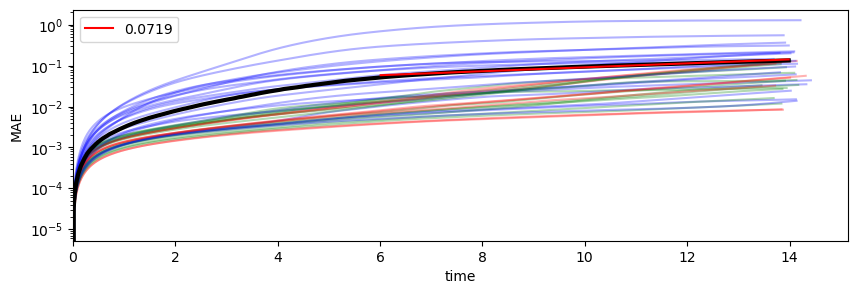

In [15]:
colors = {"rr": "r", "er": "g", "ba": "b"}
fit_range, yscale = 6.0, "log"

fig, ax = plt.subplots(figsize=(10, 3))

slopes = []
for network_type, sample_time, sample_mae in zip(test_df.network_type, times, maes):
    # ax.plot(sample_time, sample_mae, color="gray", alpha=0.3)
    ax.plot(sample_time, sample_mae, color=colors[network_type], alpha=0.3)

    mask = sample_time > fit_range
    if yscale == "log":
        *_, slope, _ = fitting.lin_log_fit(sample_time[mask], sample_mae[mask])
    else:
        *_, slope, _ = fitting.lin_fit(sample_time[mask], sample_mae[mask])
    slopes.append(slope)


final_mae = np.mean(maes, 0)
t = np.linspace(0.0, np.mean(times[:, -1]), times.shape[1], dtype=np.float32)
ax.plot(t, final_mae, "k-", linewidth=3)

mask = t > fit_range
if yscale == "log":
    fit_t, fit_mae, slope, _ = fitting.lin_log_fit(t[mask], final_mae[mask])
else:
    fit_t, fit_mae, slope, _ = fitting.lin_fit(t[mask], final_mae[mask])
print(f"slope: {np.mean(slopes):.4f} pm {np.std(slopes):.4f}")
print(f"slope of averaged curve: {slope:.4f}")
ax.plot(fit_t, fit_mae, "r-", label=f"{np.mean(slopes):.4f}")
ax.legend()

if yscale == "log":
    ax.set_yscale("log")
ax.set_xlim(left=0)
ax.set_xlabel("time")
ax.set_ylabel("MAE")
# fig.savefig(f"{FIG_DIR}/kuramoto_mae.pdf", bbox_inches="tight", pad_inches=0.0)
fig.show()